In [1]:
from keras.datasets.cifar10 import load_data
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Dense,Reshape,Flatten,Dropout,LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np

In [2]:
(trainX, trainy), (testX, testy) = load_data()

In [3]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten()) #shape of 8192
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) #shape of 1
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

In [4]:
def define_generator(latent_dim):    #latent_dim is the dimension of the latent vector (e.g., 100)
    
    model = Sequential()
    n_nodes = 128 * 8 * 8  #8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    model.summary()
    return model

In [5]:
def define_gan(generator, discriminator):
    discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
    # connect generator and discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    model.summary()
    return model

In [6]:
def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    X = dataset[ix]
    # generate class labels and assign to y
    y = np.ones((n_samples, 1)) ##Label=1 indicating they are real
    return X, y

In [7]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [8]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict using generator to generate fake samples. 
    X = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake. 
    y = np.zeros((n_samples, 1))  #Label=0 indicating they are fake
    return X, y

In [19]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch,1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
        g_model.save(f'models/cifar_generator_epochs_{str(i)}.h5')

In [20]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    # Convert to float and scale.
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5  
    return X

In [21]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                

Epoch>1, Batch 92/390, d1=0.317, d2=0.504 g=1.072
Epoch>1, Batch 93/390, d1=0.247, d2=0.528 g=1.072
Epoch>1, Batch 94/390, d1=0.212, d2=0.600 g=1.022
Epoch>1, Batch 95/390, d1=0.370, d2=0.816 g=0.862
Epoch>1, Batch 96/390, d1=0.255, d2=1.544 g=0.574
Epoch>1, Batch 97/390, d1=0.197, d2=2.582 g=0.409
Epoch>1, Batch 98/390, d1=0.238, d2=2.239 g=0.930
Epoch>1, Batch 99/390, d1=0.253, d2=0.480 g=2.709
Epoch>1, Batch 100/390, d1=0.490, d2=0.093 g=3.146
Epoch>1, Batch 101/390, d1=0.697, d2=0.270 g=2.040
Epoch>1, Batch 102/390, d1=0.558, d2=0.480 g=1.765
Epoch>1, Batch 103/390, d1=0.617, d2=0.444 g=1.673
Epoch>1, Batch 104/390, d1=0.827, d2=0.392 g=1.613
Epoch>1, Batch 105/390, d1=0.676, d2=0.362 g=1.507
Epoch>1, Batch 106/390, d1=0.397, d2=0.360 g=1.420
Epoch>1, Batch 107/390, d1=0.330, d2=0.424 g=1.229
Epoch>1, Batch 108/390, d1=0.554, d2=0.518 g=0.989
Epoch>1, Batch 109/390, d1=0.346, d2=0.716 g=0.794
Epoch>1, Batch 110/390, d1=0.354, d2=1.023 g=0.586
Epoch>1, Batch 111/390, d1=0.188, d2=1.

Epoch>1, Batch 253/390, d1=0.583, d2=0.522 g=1.194
Epoch>1, Batch 254/390, d1=0.597, d2=0.491 g=1.222
Epoch>1, Batch 255/390, d1=0.588, d2=0.465 g=1.202
Epoch>1, Batch 256/390, d1=0.584, d2=0.553 g=1.170
Epoch>1, Batch 257/390, d1=0.585, d2=0.472 g=1.121
Epoch>1, Batch 258/390, d1=0.551, d2=0.474 g=1.121
Epoch>1, Batch 259/390, d1=0.483, d2=0.523 g=1.056
Epoch>1, Batch 260/390, d1=0.463, d2=0.619 g=1.069
Epoch>1, Batch 261/390, d1=0.604, d2=0.577 g=1.017
Epoch>1, Batch 262/390, d1=0.596, d2=0.694 g=1.006
Epoch>1, Batch 263/390, d1=0.673, d2=0.768 g=0.926
Epoch>1, Batch 264/390, d1=0.568, d2=0.766 g=0.961
Epoch>1, Batch 265/390, d1=0.579, d2=0.733 g=0.869
Epoch>1, Batch 266/390, d1=0.597, d2=0.788 g=0.810
Epoch>1, Batch 267/390, d1=0.873, d2=0.913 g=0.823
Epoch>1, Batch 268/390, d1=0.605, d2=0.975 g=0.947
Epoch>1, Batch 269/390, d1=0.763, d2=0.874 g=1.028
Epoch>1, Batch 270/390, d1=0.794, d2=0.737 g=1.216
Epoch>1, Batch 271/390, d1=1.016, d2=0.592 g=1.367
Epoch>1, Batch 272/390, d1=0.81

Epoch>2, Batch 21/390, d1=0.584, d2=0.744 g=0.738
Epoch>2, Batch 22/390, d1=0.612, d2=0.713 g=0.760
Epoch>2, Batch 23/390, d1=0.615, d2=0.662 g=0.865
Epoch>2, Batch 24/390, d1=0.647, d2=0.558 g=0.950
Epoch>2, Batch 25/390, d1=0.643, d2=0.518 g=1.034
Epoch>2, Batch 26/390, d1=0.558, d2=0.449 g=1.114
Epoch>2, Batch 27/390, d1=0.573, d2=0.427 g=1.181
Epoch>2, Batch 28/390, d1=0.569, d2=0.408 g=1.233
Epoch>2, Batch 29/390, d1=0.524, d2=0.466 g=1.179
Epoch>2, Batch 30/390, d1=0.510, d2=0.469 g=1.265
Epoch>2, Batch 31/390, d1=0.517, d2=0.415 g=1.129
Epoch>2, Batch 32/390, d1=0.564, d2=0.480 g=1.186
Epoch>2, Batch 33/390, d1=0.494, d2=0.511 g=1.034
Epoch>2, Batch 34/390, d1=0.474, d2=0.476 g=1.037
Epoch>2, Batch 35/390, d1=0.528, d2=0.585 g=0.928
Epoch>2, Batch 36/390, d1=0.475, d2=0.654 g=0.861
Epoch>2, Batch 37/390, d1=0.531, d2=0.688 g=0.828
Epoch>2, Batch 38/390, d1=0.485, d2=0.697 g=0.802
Epoch>2, Batch 39/390, d1=0.583, d2=0.702 g=0.805
Epoch>2, Batch 40/390, d1=0.574, d2=0.729 g=0.825


Epoch>2, Batch 184/390, d1=0.626, d2=0.523 g=0.993
Epoch>2, Batch 185/390, d1=0.587, d2=0.571 g=0.981
Epoch>2, Batch 186/390, d1=0.598, d2=0.530 g=0.971
Epoch>2, Batch 187/390, d1=0.604, d2=0.518 g=0.966
Epoch>2, Batch 188/390, d1=0.615, d2=0.542 g=0.958
Epoch>2, Batch 189/390, d1=0.551, d2=0.582 g=0.940
Epoch>2, Batch 190/390, d1=0.590, d2=0.604 g=0.915
Epoch>2, Batch 191/390, d1=0.620, d2=0.611 g=0.835
Epoch>2, Batch 192/390, d1=0.536, d2=0.664 g=0.808
Epoch>2, Batch 193/390, d1=0.607, d2=0.708 g=0.766
Epoch>2, Batch 194/390, d1=0.637, d2=0.736 g=0.798
Epoch>2, Batch 195/390, d1=0.597, d2=0.757 g=0.729
Epoch>2, Batch 196/390, d1=0.705, d2=0.773 g=0.736
Epoch>2, Batch 197/390, d1=0.593, d2=0.782 g=0.738
Epoch>2, Batch 198/390, d1=0.687, d2=0.744 g=0.732
Epoch>2, Batch 199/390, d1=0.710, d2=0.821 g=0.704
Epoch>2, Batch 200/390, d1=0.661, d2=0.728 g=0.718
Epoch>2, Batch 201/390, d1=0.667, d2=0.747 g=0.717
Epoch>2, Batch 202/390, d1=0.624, d2=0.783 g=0.698
Epoch>2, Batch 203/390, d1=0.63

Epoch>2, Batch 345/390, d1=0.603, d2=0.774 g=0.688
Epoch>2, Batch 346/390, d1=0.636, d2=0.814 g=0.638
Epoch>2, Batch 347/390, d1=0.579, d2=0.872 g=0.598
Epoch>2, Batch 348/390, d1=0.632, d2=0.892 g=0.579
Epoch>2, Batch 349/390, d1=0.546, d2=0.964 g=0.590
Epoch>2, Batch 350/390, d1=0.613, d2=0.905 g=0.579
Epoch>2, Batch 351/390, d1=0.660, d2=0.931 g=0.611
Epoch>2, Batch 352/390, d1=0.657, d2=0.833 g=0.688
Epoch>2, Batch 353/390, d1=0.674, d2=0.745 g=0.774
Epoch>2, Batch 354/390, d1=0.663, d2=0.645 g=0.864
Epoch>2, Batch 355/390, d1=0.653, d2=0.570 g=0.965
Epoch>2, Batch 356/390, d1=0.670, d2=0.526 g=1.025
Epoch>2, Batch 357/390, d1=0.663, d2=0.479 g=1.047
Epoch>2, Batch 358/390, d1=0.673, d2=0.466 g=1.049
Epoch>2, Batch 359/390, d1=0.595, d2=0.479 g=1.075
Epoch>2, Batch 360/390, d1=0.627, d2=0.485 g=1.009
Epoch>2, Batch 361/390, d1=0.602, d2=0.521 g=0.967
Epoch>2, Batch 362/390, d1=0.583, d2=0.576 g=0.866
Epoch>2, Batch 363/390, d1=0.599, d2=0.669 g=0.774
Epoch>2, Batch 364/390, d1=0.57

Epoch>3, Batch 115/390, d1=0.535, d2=0.637 g=0.877
Epoch>3, Batch 116/390, d1=0.528, d2=0.710 g=0.812
Epoch>3, Batch 117/390, d1=0.604, d2=0.679 g=0.818
Epoch>3, Batch 118/390, d1=0.478, d2=0.712 g=0.835
Epoch>3, Batch 119/390, d1=0.491, d2=0.692 g=0.765
Epoch>3, Batch 120/390, d1=0.555, d2=0.732 g=0.817
Epoch>3, Batch 121/390, d1=0.504, d2=0.651 g=0.883
Epoch>3, Batch 122/390, d1=0.599, d2=0.649 g=0.957
Epoch>3, Batch 123/390, d1=0.538, d2=0.572 g=0.955
Epoch>3, Batch 124/390, d1=0.644, d2=0.695 g=0.923
Epoch>3, Batch 125/390, d1=0.681, d2=0.620 g=1.003
Epoch>3, Batch 126/390, d1=0.570, d2=0.629 g=0.944
Epoch>3, Batch 127/390, d1=0.614, d2=0.605 g=1.024
Epoch>3, Batch 128/390, d1=0.669, d2=0.586 g=0.995
Epoch>3, Batch 129/390, d1=0.706, d2=0.608 g=0.969
Epoch>3, Batch 130/390, d1=0.633, d2=0.631 g=0.869
Epoch>3, Batch 131/390, d1=0.652, d2=0.705 g=0.855
Epoch>3, Batch 132/390, d1=0.589, d2=0.670 g=0.877
Epoch>3, Batch 133/390, d1=0.591, d2=0.649 g=0.887
Epoch>3, Batch 134/390, d1=0.68

Epoch>3, Batch 276/390, d1=0.660, d2=0.617 g=0.891
Epoch>3, Batch 277/390, d1=0.669, d2=0.628 g=0.926
Epoch>3, Batch 278/390, d1=0.748, d2=0.640 g=0.931
Epoch>3, Batch 279/390, d1=0.723, d2=0.621 g=0.888
Epoch>3, Batch 280/390, d1=0.728, d2=0.638 g=0.908
Epoch>3, Batch 281/390, d1=0.696, d2=0.646 g=0.834
Epoch>3, Batch 282/390, d1=0.680, d2=0.706 g=0.809
Epoch>3, Batch 283/390, d1=0.818, d2=0.735 g=0.729
Epoch>3, Batch 284/390, d1=0.729, d2=0.742 g=0.680
Epoch>3, Batch 285/390, d1=0.650, d2=0.780 g=0.674
Epoch>3, Batch 286/390, d1=0.679, d2=0.793 g=0.667
Epoch>3, Batch 287/390, d1=0.713, d2=0.790 g=0.685
Epoch>3, Batch 288/390, d1=0.655, d2=0.790 g=0.663
Epoch>3, Batch 289/390, d1=0.697, d2=0.852 g=0.696
Epoch>3, Batch 290/390, d1=0.646, d2=0.778 g=0.680
Epoch>3, Batch 291/390, d1=0.720, d2=0.736 g=0.686
Epoch>3, Batch 292/390, d1=0.728, d2=0.813 g=0.704
Epoch>3, Batch 293/390, d1=0.686, d2=0.761 g=0.704
Epoch>3, Batch 294/390, d1=0.721, d2=0.741 g=0.700
Epoch>3, Batch 295/390, d1=0.69

Epoch>4, Batch 45/390, d1=0.713, d2=0.552 g=0.963
Epoch>4, Batch 46/390, d1=0.722, d2=0.544 g=0.931
Epoch>4, Batch 47/390, d1=0.694, d2=0.582 g=0.901
Epoch>4, Batch 48/390, d1=0.701, d2=0.606 g=0.860
Epoch>4, Batch 49/390, d1=0.681, d2=0.659 g=0.816
Epoch>4, Batch 50/390, d1=0.647, d2=0.670 g=0.784
Epoch>4, Batch 51/390, d1=0.656, d2=0.722 g=0.760
Epoch>4, Batch 52/390, d1=0.628, d2=0.702 g=0.761
Epoch>4, Batch 53/390, d1=0.615, d2=0.704 g=0.719
Epoch>4, Batch 54/390, d1=0.642, d2=0.681 g=0.720
Epoch>4, Batch 55/390, d1=0.648, d2=0.732 g=0.737
Epoch>4, Batch 56/390, d1=0.618, d2=0.691 g=0.753
Epoch>4, Batch 57/390, d1=0.621, d2=0.696 g=0.783
Epoch>4, Batch 58/390, d1=0.639, d2=0.662 g=0.794
Epoch>4, Batch 59/390, d1=0.603, d2=0.627 g=0.809
Epoch>4, Batch 60/390, d1=0.628, d2=0.627 g=0.819
Epoch>4, Batch 61/390, d1=0.615, d2=0.613 g=0.834
Epoch>4, Batch 62/390, d1=0.643, d2=0.599 g=0.838
Epoch>4, Batch 63/390, d1=0.608, d2=0.621 g=0.820
Epoch>4, Batch 64/390, d1=0.588, d2=0.643 g=0.815


Epoch>4, Batch 207/390, d1=0.667, d2=0.625 g=0.826
Epoch>4, Batch 208/390, d1=0.648, d2=0.632 g=0.806
Epoch>4, Batch 209/390, d1=0.710, d2=0.625 g=0.809
Epoch>4, Batch 210/390, d1=0.691, d2=0.654 g=0.795
Epoch>4, Batch 211/390, d1=0.681, d2=0.670 g=0.795
Epoch>4, Batch 212/390, d1=0.684, d2=0.659 g=0.776
Epoch>4, Batch 213/390, d1=0.678, d2=0.695 g=0.794
Epoch>4, Batch 214/390, d1=0.702, d2=0.648 g=0.817
Epoch>4, Batch 215/390, d1=0.661, d2=0.646 g=0.864
Epoch>4, Batch 216/390, d1=0.719, d2=0.621 g=0.886
Epoch>4, Batch 217/390, d1=0.693, d2=0.607 g=0.920
Epoch>4, Batch 218/390, d1=0.677, d2=0.575 g=0.918
Epoch>4, Batch 219/390, d1=0.651, d2=0.558 g=0.919
Epoch>4, Batch 220/390, d1=0.667, d2=0.566 g=0.907
Epoch>4, Batch 221/390, d1=0.649, d2=0.609 g=0.886
Epoch>4, Batch 222/390, d1=0.643, d2=0.623 g=0.894
Epoch>4, Batch 223/390, d1=0.629, d2=0.658 g=0.862
Epoch>4, Batch 224/390, d1=0.627, d2=0.617 g=0.858
Epoch>4, Batch 225/390, d1=0.634, d2=0.613 g=0.854
Epoch>4, Batch 226/390, d1=0.67

Epoch>4, Batch 368/390, d1=0.727, d2=0.653 g=0.811
Epoch>4, Batch 369/390, d1=0.683, d2=0.628 g=0.816
Epoch>4, Batch 370/390, d1=0.690, d2=0.636 g=0.828
Epoch>4, Batch 371/390, d1=0.655, d2=0.656 g=0.822
Epoch>4, Batch 372/390, d1=0.715, d2=0.652 g=0.827
Epoch>4, Batch 373/390, d1=0.698, d2=0.654 g=0.826
Epoch>4, Batch 374/390, d1=0.685, d2=0.627 g=0.835
Epoch>4, Batch 375/390, d1=0.676, d2=0.631 g=0.830
Epoch>4, Batch 376/390, d1=0.731, d2=0.610 g=0.878
Epoch>4, Batch 377/390, d1=0.679, d2=0.588 g=0.891
Epoch>4, Batch 378/390, d1=0.707, d2=0.571 g=0.928
Epoch>4, Batch 379/390, d1=0.716, d2=0.566 g=0.933
Epoch>4, Batch 380/390, d1=0.694, d2=0.558 g=0.964
Epoch>4, Batch 381/390, d1=0.691, d2=0.523 g=0.951
Epoch>4, Batch 382/390, d1=0.702, d2=0.557 g=0.904
Epoch>4, Batch 383/390, d1=0.732, d2=0.600 g=0.904
Epoch>4, Batch 384/390, d1=0.698, d2=0.604 g=0.849
Epoch>4, Batch 385/390, d1=0.726, d2=0.634 g=0.835
Epoch>4, Batch 386/390, d1=0.701, d2=0.667 g=0.816
Epoch>4, Batch 387/390, d1=0.68

Epoch>5, Batch 138/390, d1=0.691, d2=0.586 g=0.843
Epoch>5, Batch 139/390, d1=0.714, d2=0.627 g=0.837
Epoch>5, Batch 140/390, d1=0.680, d2=0.657 g=0.842
Epoch>5, Batch 141/390, d1=0.726, d2=0.621 g=0.821
Epoch>5, Batch 142/390, d1=0.698, d2=0.642 g=0.823
Epoch>5, Batch 143/390, d1=0.726, d2=0.649 g=0.827
Epoch>5, Batch 144/390, d1=0.697, d2=0.640 g=0.808
Epoch>5, Batch 145/390, d1=0.677, d2=0.660 g=0.807
Epoch>5, Batch 146/390, d1=0.697, d2=0.654 g=0.788
Epoch>5, Batch 147/390, d1=0.679, d2=0.673 g=0.812
Epoch>5, Batch 148/390, d1=0.708, d2=0.646 g=0.833
Epoch>5, Batch 149/390, d1=0.726, d2=0.635 g=0.855
Epoch>5, Batch 150/390, d1=0.719, d2=0.611 g=0.862
Epoch>5, Batch 151/390, d1=0.720, d2=0.609 g=0.851
Epoch>5, Batch 152/390, d1=0.728, d2=0.612 g=0.872
Epoch>5, Batch 153/390, d1=0.715, d2=0.633 g=0.855
Epoch>5, Batch 154/390, d1=0.720, d2=0.593 g=0.869
Epoch>5, Batch 155/390, d1=0.711, d2=0.616 g=0.879
Epoch>5, Batch 156/390, d1=0.742, d2=0.600 g=0.871
Epoch>5, Batch 157/390, d1=0.71

Epoch>5, Batch 299/390, d1=0.724, d2=0.625 g=0.867
Epoch>5, Batch 300/390, d1=0.692, d2=0.623 g=0.828
Epoch>5, Batch 301/390, d1=0.719, d2=0.651 g=0.797
Epoch>5, Batch 302/390, d1=0.789, d2=0.679 g=0.769
Epoch>5, Batch 303/390, d1=0.710, d2=0.680 g=0.801
Epoch>5, Batch 304/390, d1=0.745, d2=0.669 g=0.828
Epoch>5, Batch 305/390, d1=0.743, d2=0.692 g=0.819
Epoch>5, Batch 306/390, d1=0.745, d2=0.642 g=0.825
Epoch>5, Batch 307/390, d1=0.745, d2=0.638 g=0.850
Epoch>5, Batch 308/390, d1=0.727, d2=0.680 g=0.879
Epoch>5, Batch 309/390, d1=0.711, d2=0.615 g=0.960
Epoch>5, Batch 310/390, d1=0.708, d2=0.549 g=1.092
Epoch>5, Batch 311/390, d1=0.651, d2=0.453 g=1.219
Epoch>5, Batch 312/390, d1=0.698, d2=0.461 g=1.180
Epoch>5, Batch 313/390, d1=0.653, d2=0.484 g=1.007
Epoch>5, Batch 314/390, d1=0.689, d2=0.665 g=0.813
Epoch>5, Batch 315/390, d1=0.684, d2=0.750 g=0.695
Epoch>5, Batch 316/390, d1=0.670, d2=0.861 g=0.632
Epoch>5, Batch 317/390, d1=0.676, d2=0.968 g=0.602
Epoch>5, Batch 318/390, d1=0.68

Epoch>6, Batch 68/390, d1=0.708, d2=0.719 g=0.737
Epoch>6, Batch 69/390, d1=0.761, d2=0.722 g=0.721
Epoch>6, Batch 70/390, d1=0.745, d2=0.714 g=0.713
Epoch>6, Batch 71/390, d1=0.738, d2=0.705 g=0.735
Epoch>6, Batch 72/390, d1=0.701, d2=0.710 g=0.746
Epoch>6, Batch 73/390, d1=0.726, d2=0.679 g=0.776
Epoch>6, Batch 74/390, d1=0.716, d2=0.658 g=0.803
Epoch>6, Batch 75/390, d1=0.721, d2=0.625 g=0.832
Epoch>6, Batch 76/390, d1=0.713, d2=0.632 g=0.877
Epoch>6, Batch 77/390, d1=0.720, d2=0.604 g=0.835
Epoch>6, Batch 78/390, d1=0.749, d2=0.627 g=0.812
Epoch>6, Batch 79/390, d1=0.731, d2=0.658 g=0.811
Epoch>6, Batch 80/390, d1=0.737, d2=0.661 g=0.786
Epoch>6, Batch 81/390, d1=0.716, d2=0.672 g=0.781
Epoch>6, Batch 82/390, d1=0.734, d2=0.647 g=0.743
Epoch>6, Batch 83/390, d1=0.738, d2=0.686 g=0.757
Epoch>6, Batch 84/390, d1=0.733, d2=0.712 g=0.718
Epoch>6, Batch 85/390, d1=0.684, d2=0.698 g=0.728
Epoch>6, Batch 86/390, d1=0.680, d2=0.717 g=0.726
Epoch>6, Batch 87/390, d1=0.647, d2=0.719 g=0.713


Epoch>6, Batch 230/390, d1=0.681, d2=0.673 g=0.761
Epoch>6, Batch 231/390, d1=0.676, d2=0.683 g=0.739
Epoch>6, Batch 232/390, d1=0.755, d2=0.708 g=0.723
Epoch>6, Batch 233/390, d1=0.685, d2=0.739 g=0.690
Epoch>6, Batch 234/390, d1=0.731, d2=0.763 g=0.694
Epoch>6, Batch 235/390, d1=0.697, d2=0.739 g=0.695
Epoch>6, Batch 236/390, d1=0.677, d2=0.707 g=0.729
Epoch>6, Batch 237/390, d1=0.680, d2=0.675 g=0.771
Epoch>6, Batch 238/390, d1=0.711, d2=0.655 g=0.794
Epoch>6, Batch 239/390, d1=0.688, d2=0.627 g=0.811
Epoch>6, Batch 240/390, d1=0.648, d2=0.628 g=0.817
Epoch>6, Batch 241/390, d1=0.652, d2=0.657 g=0.782
Epoch>6, Batch 242/390, d1=0.662, d2=0.698 g=0.761
Epoch>6, Batch 243/390, d1=0.640, d2=0.705 g=0.748
Epoch>6, Batch 244/390, d1=0.639, d2=0.690 g=0.769
Epoch>6, Batch 245/390, d1=0.671, d2=0.649 g=0.833
Epoch>6, Batch 246/390, d1=0.621, d2=0.636 g=0.847
Epoch>6, Batch 247/390, d1=0.706, d2=0.715 g=0.732
Epoch>6, Batch 248/390, d1=0.745, d2=0.756 g=0.723
Epoch>6, Batch 249/390, d1=0.75

Epoch>7, Batch 1/390, d1=0.679, d2=0.725 g=0.695
Epoch>7, Batch 2/390, d1=0.659, d2=0.760 g=0.699
Epoch>7, Batch 3/390, d1=0.667, d2=0.748 g=0.699
Epoch>7, Batch 4/390, d1=0.651, d2=0.757 g=0.695
Epoch>7, Batch 5/390, d1=0.658, d2=0.721 g=0.716
Epoch>7, Batch 6/390, d1=0.687, d2=0.709 g=0.731
Epoch>7, Batch 7/390, d1=0.682, d2=0.721 g=0.771
Epoch>7, Batch 8/390, d1=0.689, d2=0.657 g=0.787
Epoch>7, Batch 9/390, d1=0.715, d2=0.650 g=0.803
Epoch>7, Batch 10/390, d1=0.717, d2=0.669 g=0.811
Epoch>7, Batch 11/390, d1=0.698, d2=0.687 g=0.772
Epoch>7, Batch 12/390, d1=0.741, d2=0.723 g=0.803
Epoch>7, Batch 13/390, d1=0.724, d2=0.695 g=0.752
Epoch>7, Batch 14/390, d1=0.716, d2=0.709 g=0.721
Epoch>7, Batch 15/390, d1=0.729, d2=0.696 g=0.719
Epoch>7, Batch 16/390, d1=0.708, d2=0.712 g=0.721
Epoch>7, Batch 17/390, d1=0.688, d2=0.695 g=0.745
Epoch>7, Batch 18/390, d1=0.738, d2=0.684 g=0.780
Epoch>7, Batch 19/390, d1=0.697, d2=0.635 g=0.844
Epoch>7, Batch 20/390, d1=0.690, d2=0.619 g=0.879
Epoch>7, 

Epoch>7, Batch 164/390, d1=0.665, d2=0.659 g=0.801
Epoch>7, Batch 165/390, d1=0.733, d2=0.679 g=0.786
Epoch>7, Batch 166/390, d1=0.717, d2=0.690 g=0.767
Epoch>7, Batch 167/390, d1=0.669, d2=0.697 g=0.720
Epoch>7, Batch 168/390, d1=0.686, d2=0.704 g=0.733
Epoch>7, Batch 169/390, d1=0.687, d2=0.705 g=0.747
Epoch>7, Batch 170/390, d1=0.669, d2=0.696 g=0.745
Epoch>7, Batch 171/390, d1=0.665, d2=0.692 g=0.771
Epoch>7, Batch 172/390, d1=0.702, d2=0.654 g=0.787
Epoch>7, Batch 173/390, d1=0.673, d2=0.629 g=0.807
Epoch>7, Batch 174/390, d1=0.683, d2=0.643 g=0.806
Epoch>7, Batch 175/390, d1=0.691, d2=0.662 g=0.781
Epoch>7, Batch 176/390, d1=0.668, d2=0.665 g=0.776
Epoch>7, Batch 177/390, d1=0.722, d2=0.659 g=0.751
Epoch>7, Batch 178/390, d1=0.716, d2=0.648 g=0.779
Epoch>7, Batch 179/390, d1=0.710, d2=0.681 g=0.800
Epoch>7, Batch 180/390, d1=0.688, d2=0.645 g=0.823
Epoch>7, Batch 181/390, d1=0.721, d2=0.624 g=0.827
Epoch>7, Batch 182/390, d1=0.728, d2=0.608 g=0.835
Epoch>7, Batch 183/390, d1=0.75

Epoch>7, Batch 325/390, d1=0.552, d2=0.724 g=0.730
Epoch>7, Batch 326/390, d1=0.545, d2=0.707 g=0.722
Epoch>7, Batch 327/390, d1=0.562, d2=0.729 g=0.720
Epoch>7, Batch 328/390, d1=0.607, d2=0.703 g=0.737
Epoch>7, Batch 329/390, d1=0.592, d2=0.719 g=0.743
Epoch>7, Batch 330/390, d1=0.578, d2=0.720 g=0.771
Epoch>7, Batch 331/390, d1=0.572, d2=0.719 g=0.756
Epoch>7, Batch 332/390, d1=0.597, d2=0.727 g=0.753
Epoch>7, Batch 333/390, d1=0.592, d2=0.723 g=0.726
Epoch>7, Batch 334/390, d1=0.590, d2=0.739 g=0.739
Epoch>7, Batch 335/390, d1=0.626, d2=0.726 g=0.759
Epoch>7, Batch 336/390, d1=0.675, d2=0.711 g=0.799
Epoch>7, Batch 337/390, d1=0.654, d2=0.725 g=0.847
Epoch>7, Batch 338/390, d1=0.642, d2=0.644 g=0.850
Epoch>7, Batch 339/390, d1=0.668, d2=0.630 g=0.900
Epoch>7, Batch 340/390, d1=0.633, d2=0.664 g=0.905
Epoch>7, Batch 341/390, d1=0.703, d2=0.616 g=0.937
Epoch>7, Batch 342/390, d1=0.681, d2=0.592 g=0.993
Epoch>7, Batch 343/390, d1=0.662, d2=0.642 g=0.907
Epoch>7, Batch 344/390, d1=0.66

Epoch>8, Batch 95/390, d1=0.699, d2=0.627 g=0.802
Epoch>8, Batch 96/390, d1=0.677, d2=0.630 g=0.836
Epoch>8, Batch 97/390, d1=0.715, d2=0.631 g=0.824
Epoch>8, Batch 98/390, d1=0.708, d2=0.638 g=0.847
Epoch>8, Batch 99/390, d1=0.742, d2=0.600 g=0.868
Epoch>8, Batch 100/390, d1=0.732, d2=0.610 g=0.883
Epoch>8, Batch 101/390, d1=0.707, d2=0.616 g=0.875
Epoch>8, Batch 102/390, d1=0.675, d2=0.584 g=0.854
Epoch>8, Batch 103/390, d1=0.767, d2=0.665 g=0.814
Epoch>8, Batch 104/390, d1=0.746, d2=0.655 g=0.814
Epoch>8, Batch 105/390, d1=0.665, d2=0.668 g=0.787
Epoch>8, Batch 106/390, d1=0.697, d2=0.683 g=0.756
Epoch>8, Batch 107/390, d1=0.699, d2=0.683 g=0.766
Epoch>8, Batch 108/390, d1=0.712, d2=0.695 g=0.770
Epoch>8, Batch 109/390, d1=0.636, d2=0.703 g=0.720
Epoch>8, Batch 110/390, d1=0.674, d2=0.764 g=0.748
Epoch>8, Batch 111/390, d1=0.701, d2=0.721 g=0.734
Epoch>8, Batch 112/390, d1=0.681, d2=0.752 g=0.694
Epoch>8, Batch 113/390, d1=0.666, d2=0.776 g=0.687
Epoch>8, Batch 114/390, d1=0.676, d2

Epoch>8, Batch 256/390, d1=0.711, d2=0.719 g=0.718
Epoch>8, Batch 257/390, d1=0.681, d2=0.713 g=0.726
Epoch>8, Batch 258/390, d1=0.660, d2=0.697 g=0.749
Epoch>8, Batch 259/390, d1=0.722, d2=0.691 g=0.745
Epoch>8, Batch 260/390, d1=0.693, d2=0.681 g=0.759
Epoch>8, Batch 261/390, d1=0.687, d2=0.667 g=0.752
Epoch>8, Batch 262/390, d1=0.674, d2=0.676 g=0.744
Epoch>8, Batch 263/390, d1=0.695, d2=0.685 g=0.750
Epoch>8, Batch 264/390, d1=0.679, d2=0.674 g=0.764
Epoch>8, Batch 265/390, d1=0.645, d2=0.663 g=0.748
Epoch>8, Batch 266/390, d1=0.660, d2=0.672 g=0.761
Epoch>8, Batch 267/390, d1=0.638, d2=0.655 g=0.742
Epoch>8, Batch 268/390, d1=0.670, d2=0.692 g=0.734
Epoch>8, Batch 269/390, d1=0.685, d2=0.692 g=0.745
Epoch>8, Batch 270/390, d1=0.666, d2=0.690 g=0.751
Epoch>8, Batch 271/390, d1=0.681, d2=0.660 g=0.761
Epoch>8, Batch 272/390, d1=0.659, d2=0.638 g=0.779
Epoch>8, Batch 273/390, d1=0.678, d2=0.662 g=0.770
Epoch>8, Batch 274/390, d1=0.661, d2=0.650 g=0.779
Epoch>8, Batch 275/390, d1=0.69

Epoch>9, Batch 24/390, d1=0.667, d2=0.615 g=0.820
Epoch>9, Batch 25/390, d1=0.668, d2=0.625 g=0.816
Epoch>9, Batch 26/390, d1=0.675, d2=0.667 g=0.762
Epoch>9, Batch 27/390, d1=0.662, d2=0.676 g=0.756
Epoch>9, Batch 28/390, d1=0.648, d2=0.693 g=0.738
Epoch>9, Batch 29/390, d1=0.667, d2=0.686 g=0.723
Epoch>9, Batch 30/390, d1=0.726, d2=0.725 g=0.678
Epoch>9, Batch 31/390, d1=0.674, d2=0.742 g=0.674
Epoch>9, Batch 32/390, d1=0.664, d2=0.742 g=0.664
Epoch>9, Batch 33/390, d1=0.643, d2=0.756 g=0.674
Epoch>9, Batch 34/390, d1=0.642, d2=0.762 g=0.665
Epoch>9, Batch 35/390, d1=0.668, d2=0.746 g=0.701
Epoch>9, Batch 36/390, d1=0.716, d2=0.713 g=0.707
Epoch>9, Batch 37/390, d1=0.689, d2=0.742 g=0.717
Epoch>9, Batch 38/390, d1=0.692, d2=0.705 g=0.741
Epoch>9, Batch 39/390, d1=0.716, d2=0.685 g=0.770
Epoch>9, Batch 40/390, d1=0.718, d2=0.689 g=0.764
Epoch>9, Batch 41/390, d1=0.723, d2=0.665 g=0.752
Epoch>9, Batch 42/390, d1=0.722, d2=0.664 g=0.758
Epoch>9, Batch 43/390, d1=0.674, d2=0.658 g=0.774


Epoch>9, Batch 187/390, d1=0.689, d2=0.660 g=0.744
Epoch>9, Batch 188/390, d1=0.663, d2=0.685 g=0.731
Epoch>9, Batch 189/390, d1=0.688, d2=0.717 g=0.731
Epoch>9, Batch 190/390, d1=0.658, d2=0.707 g=0.709
Epoch>9, Batch 191/390, d1=0.686, d2=0.739 g=0.687
Epoch>9, Batch 192/390, d1=0.699, d2=0.731 g=0.696
Epoch>9, Batch 193/390, d1=0.687, d2=0.734 g=0.687
Epoch>9, Batch 194/390, d1=0.694, d2=0.752 g=0.699
Epoch>9, Batch 195/390, d1=0.722, d2=0.732 g=0.706
Epoch>9, Batch 196/390, d1=0.718, d2=0.703 g=0.709
Epoch>9, Batch 197/390, d1=0.691, d2=0.766 g=0.718
Epoch>9, Batch 198/390, d1=0.702, d2=0.749 g=0.707
Epoch>9, Batch 199/390, d1=0.732, d2=0.709 g=0.706
Epoch>9, Batch 200/390, d1=0.732, d2=0.731 g=0.723
Epoch>9, Batch 201/390, d1=0.728, d2=0.720 g=0.761
Epoch>9, Batch 202/390, d1=0.731, d2=0.648 g=0.791
Epoch>9, Batch 203/390, d1=0.736, d2=0.606 g=0.827
Epoch>9, Batch 204/390, d1=0.718, d2=0.605 g=0.843
Epoch>9, Batch 205/390, d1=0.704, d2=0.604 g=0.878
Epoch>9, Batch 206/390, d1=0.69

Epoch>9, Batch 348/390, d1=0.705, d2=0.709 g=0.739
Epoch>9, Batch 349/390, d1=0.693, d2=0.703 g=0.725
Epoch>9, Batch 350/390, d1=0.649, d2=0.707 g=0.716
Epoch>9, Batch 351/390, d1=0.672, d2=0.720 g=0.710
Epoch>9, Batch 352/390, d1=0.665, d2=0.725 g=0.718
Epoch>9, Batch 353/390, d1=0.658, d2=0.700 g=0.714
Epoch>9, Batch 354/390, d1=0.689, d2=0.733 g=0.722
Epoch>9, Batch 355/390, d1=0.682, d2=0.686 g=0.732
Epoch>9, Batch 356/390, d1=0.696, d2=0.696 g=0.714
Epoch>9, Batch 357/390, d1=0.681, d2=0.713 g=0.712
Epoch>9, Batch 358/390, d1=0.686, d2=0.701 g=0.719
Epoch>9, Batch 359/390, d1=0.674, d2=0.743 g=0.702
Epoch>9, Batch 360/390, d1=0.674, d2=0.727 g=0.707
Epoch>9, Batch 361/390, d1=0.644, d2=0.734 g=0.700
Epoch>9, Batch 362/390, d1=0.684, d2=0.699 g=0.719
Epoch>9, Batch 363/390, d1=0.680, d2=0.689 g=0.738
Epoch>9, Batch 364/390, d1=0.668, d2=0.677 g=0.765
Epoch>9, Batch 365/390, d1=0.709, d2=0.678 g=0.769
Epoch>9, Batch 366/390, d1=0.685, d2=0.647 g=0.761
Epoch>9, Batch 367/390, d1=0.72

Epoch>10, Batch 116/390, d1=0.716, d2=0.648 g=0.766
Epoch>10, Batch 117/390, d1=0.764, d2=0.675 g=0.779
Epoch>10, Batch 118/390, d1=0.722, d2=0.654 g=0.790
Epoch>10, Batch 119/390, d1=0.727, d2=0.639 g=0.783
Epoch>10, Batch 120/390, d1=0.723, d2=0.668 g=0.788
Epoch>10, Batch 121/390, d1=0.740, d2=0.637 g=0.807
Epoch>10, Batch 122/390, d1=0.733, d2=0.639 g=0.791
Epoch>10, Batch 123/390, d1=0.733, d2=0.645 g=0.772
Epoch>10, Batch 124/390, d1=0.739, d2=0.675 g=0.772
Epoch>10, Batch 125/390, d1=0.713, d2=0.656 g=0.763
Epoch>10, Batch 126/390, d1=0.717, d2=0.669 g=0.764
Epoch>10, Batch 127/390, d1=0.712, d2=0.673 g=0.769
Epoch>10, Batch 128/390, d1=0.742, d2=0.686 g=0.754
Epoch>10, Batch 129/390, d1=0.684, d2=0.667 g=0.757
Epoch>10, Batch 130/390, d1=0.660, d2=0.665 g=0.755
Epoch>10, Batch 131/390, d1=0.644, d2=0.672 g=0.754
Epoch>10, Batch 132/390, d1=0.670, d2=0.692 g=0.750
Epoch>10, Batch 133/390, d1=0.661, d2=0.676 g=0.748
Epoch>10, Batch 134/390, d1=0.646, d2=0.678 g=0.757
Epoch>10, Ba

Epoch>10, Batch 274/390, d1=0.671, d2=0.700 g=0.726
Epoch>10, Batch 275/390, d1=0.679, d2=0.700 g=0.712
Epoch>10, Batch 276/390, d1=0.677, d2=0.727 g=0.704
Epoch>10, Batch 277/390, d1=0.657, d2=0.732 g=0.695
Epoch>10, Batch 278/390, d1=0.688, d2=0.731 g=0.703
Epoch>10, Batch 279/390, d1=0.689, d2=0.734 g=0.707
Epoch>10, Batch 280/390, d1=0.701, d2=0.726 g=0.711
Epoch>10, Batch 281/390, d1=0.704, d2=0.699 g=0.722
Epoch>10, Batch 282/390, d1=0.717, d2=0.688 g=0.720
Epoch>10, Batch 283/390, d1=0.767, d2=0.726 g=0.735
Epoch>10, Batch 284/390, d1=0.714, d2=0.683 g=0.764
Epoch>10, Batch 285/390, d1=0.679, d2=0.647 g=0.785
Epoch>10, Batch 286/390, d1=0.733, d2=0.642 g=0.783
Epoch>10, Batch 287/390, d1=0.718, d2=0.633 g=0.822
Epoch>10, Batch 288/390, d1=0.717, d2=0.608 g=0.829
Epoch>10, Batch 289/390, d1=0.707, d2=0.620 g=0.818
Epoch>10, Batch 290/390, d1=0.696, d2=0.623 g=0.814
Epoch>10, Batch 291/390, d1=0.696, d2=0.641 g=0.797
Epoch>10, Batch 292/390, d1=0.701, d2=0.665 g=0.785
Epoch>10, Ba

In [22]:
import matplotlib.pyplot as plt
# Plot generated images 
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()

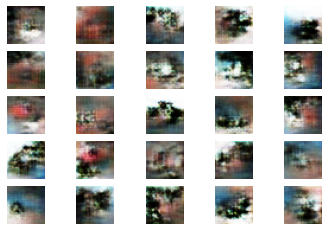

In [26]:
from tensorflow.keras.models import load_model

latent_points = generate_latent_points(100, 25) 
model = load_model("models/cifar_generator_epochs_9.h5")
X = model.predict(latent_points)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)